<a href="https://colab.research.google.com/github/Martinccv/Clases-DS/blob/main/Clase27_boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bagging

Vamos a utilizar el siguiente dataset: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

Las siguientes celdas lo descargan e importan:

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1X0MT5YFVOduVogJ9cZKjCJ7fs-OdVuAT' -O weather.csv

In [ ]:
df = pd.read_csv('https://docs.google.com/uc?export=download&id=1X0MT5YFVOduVogJ9cZKjCJ7fs-OdVuAT')

In [ ]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


Vamos a descartar las columnas:

- Sunshine          
- Evaporation       
- Cloud3pm          
- Cloud9am  
- Location
- Date       
- WindGustDir
- WindDir9am

In [ ]:
to_drop = ['Sunshine','Evaporation','Cloud3pm','Cloud9am','Location','Date', 'WindGustDir', 'WindDir9am']
df = df.drop(columns=to_drop)
df.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,13.4,22.9,0.6,44.0,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No
1,7.4,25.1,0.0,44.0,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No
2,12.9,25.7,0.0,46.0,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No
3,9.2,28.0,0.0,24.0,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No
4,17.5,32.3,1.0,41.0,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No


In [ ]:
df.shape

(145460, 15)

Descartar todas las filas que tengan nulos:

In [ ]:
df = df.dropna()

In [ ]:
df.shape

(119016, 15)

Separamos en X e y. Nuestro objetivo es predecir si va a llover mañana.

In [ ]:
X = df.copy().drop("RainTomorrow", axis=1)
y = df.RainTomorrow.copy()

Aplicamos train test split. El set de test tendrá un 20% de los datos con un random state de 42 y stratify.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Aplicar one hot encoder a las variables categóricas.

Recuerden hacer fit en train y luego en test solo transform.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False).fit(X_train[["WindDir3pm", "RainToday"]])

# Train

encoded = ohe.transform(X_train[["WindDir3pm", "RainToday"]])
encoded_df = pd.DataFrame(columns=ohe.get_feature_names_out(), data= encoded, index=X_train.index)

X_train = pd.concat([X_train, encoded_df],  axis='columns')

# Test

encoded_test = ohe.transform(X_test[["WindDir3pm", "RainToday"]])
encoded_test_df = pd.DataFrame(columns=ohe.get_feature_names_out(), data= encoded_test, index=X_test.index)

X_test = pd.concat([X_test, encoded_test_df],  axis='columns')



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Dropear las columnas originales:

In [ ]:
X_train = X_train.drop(["WindDir3pm", "RainToday"], axis=1)
X_test = X_test.drop(["WindDir3pm", "RainToday"], axis=1)

Llevar el target a una variable numérica:

- 1 si va a llover mañana
- 0 si no va a llover mañana

In [ ]:
y_train = y_train.map({'Yes':1,'No':0})
y_test = y_test.map({'Yes':1,'No':0})

Entrenar un arbol de decision con:
- max_depth=10
- random_state=0

y obtener el classification report para train y test.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=10, random_state=0).fit(X_train, y_train)
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

from sklearn.metrics import classification_report


print(classification_report(y_train, train_pred))
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92     74409
           1       0.79      0.56      0.65     20803

    accuracy                           0.87     95212
   macro avg       0.84      0.76      0.79     95212
weighted avg       0.86      0.87      0.86     95212

              precision    recall  f1-score   support

           0       0.87      0.94      0.90     18603
           1       0.70      0.49      0.58      5201

    accuracy                           0.84     23804
   macro avg       0.78      0.72      0.74     23804
weighted avg       0.83      0.84      0.83     23804



Ahora, usar un Bagging Classifier armado con árboles de decisión:
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

Los árboles que usemos en este clasificador, deberán tener la misma profundidad máxima (max_depth) que el árbol que entrenamos recién.

Además usar:

- n_estimators = 200
- n_jobs = -1 -> ¿Qué pasa si sacamos esto?
- random_state = 0 -> En el arbol y en el BaggingClassifier

In [ ]:
%%time
from sklearn.ensemble import BaggingClassifier

clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10, random_state=0), n_estimators = 200, n_jobs = -1, random_state=0)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.89      0.97      0.93     74409
           1       0.85      0.56      0.67     20803

    accuracy                           0.88     95212
   macro avg       0.87      0.76      0.80     95212
weighted avg       0.88      0.88      0.87     95212

              precision    recall  f1-score   support

           0       0.87      0.96      0.91     18603
           1       0.76      0.50      0.60      5201

    accuracy                           0.86     23804
   macro avg       0.82      0.73      0.76     23804
weighted avg       0.85      0.86      0.85     23804

CPU times: user 1.59 s, sys: 509 ms, total: 2.1 s
Wall time: 1min 46s


Ahora, probar con un RandomForestClassifier.

Los hiperparámetros serán igual que los anteriores:

- max_depth=10
- n_estimators=200
- n_jobs=-1
- random_state=0

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=10, n_estimators = 200, n_jobs = -1, random_state=0)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92     74409
           1       0.84      0.49      0.62     20803

    accuracy                           0.87     95212
   macro avg       0.85      0.73      0.77     95212
weighted avg       0.86      0.87      0.85     95212

              precision    recall  f1-score   support

           0       0.86      0.96      0.91     18603
           1       0.78      0.46      0.58      5201

    accuracy                           0.85     23804
   macro avg       0.82      0.71      0.74     23804
weighted avg       0.85      0.85      0.84     23804

CPU times: user 37.4 s, sys: 170 ms, total: 37.6 s
Wall time: 21.7 s


Ahora, en el random forest, imprimir la importancia de las features:

In [ ]:
clf.feature_importances_

array([0.02881054, 0.02850598, 0.09102755, 0.06873099, 0.01320222,
       0.01649553, 0.0752408 , 0.36632465, 0.05386588, 0.07170833,
       0.02159009, 0.04216529, 0.00063554, 0.00066353, 0.00059856,
       0.00303354, 0.00157787, 0.00178885, 0.00224139, 0.0018103 ,
       0.00123713, 0.00080913, 0.00097969, 0.00115743, 0.00114065,
       0.00120665, 0.00156089, 0.00092983, 0.04669038, 0.0542708 ])

In [ ]:
fi = pd.DataFrame(columns=["FEATURE", "IMPORTANCE"])
fi["FEATURE"] = X_train.columns
fi["IMPORTANCE"] = clf.feature_importances_
fi = fi.sort_values("IMPORTANCE", ascending=False)

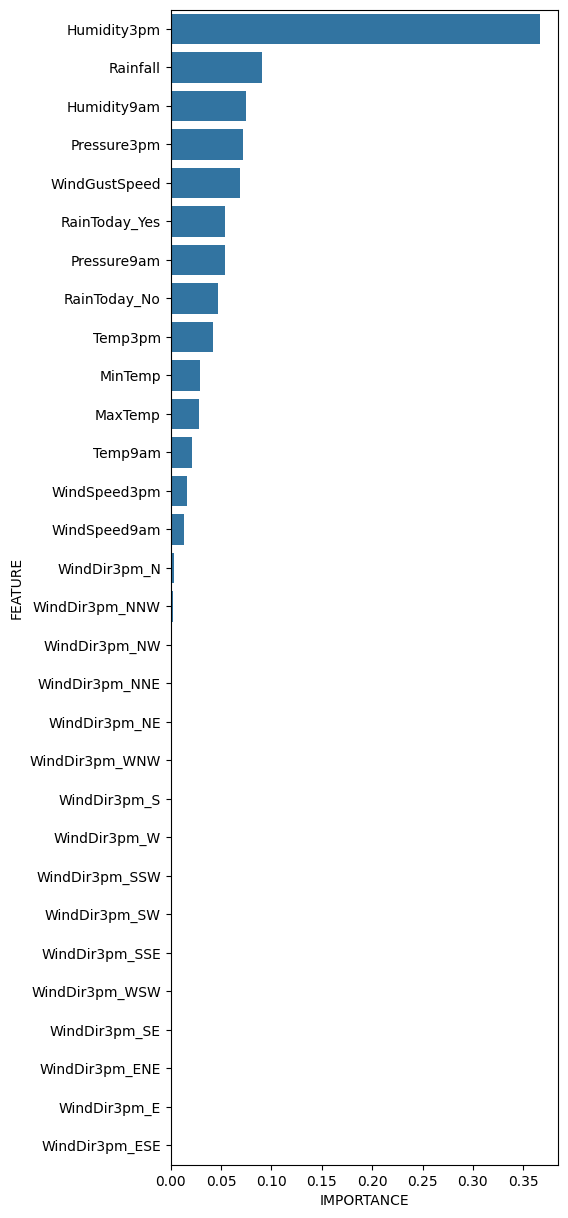

In [ ]:
plt.figure(figsize=(5, 15))
sns.barplot(y=fi.FEATURE, x=fi.IMPORTANCE)
plt.show()

Ahora, aplicar random forest en su proyecto del primer sprint.

Buscar los mejores hiperparámetros con grid search y finalmente imprimir el feature importance de las variables que utilizaron para entrenar.

# Boosting

Ahora, vamos a trabajar sobre los mismos datos que ya pre-procesamos pero vamos a entrenar modelos de boosting.

Arrancamos por Adaboost.

### Adaboost

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

En general, en Adaboost se utilizan como estimadores "débiles", árboles de decision con max_depth = 1.

Vamos a entrenar Adaboost utilizando:

- n_estimators = 200
- random_state = 0

Y evaluarlo. Imprimir el classification_report de train y de test.

Medir el tiempo que demora en entrenar Adaboost con %%time

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
%%time
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators = 200, random_state=0)
ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.87      0.95      0.91     74409
           1       0.74      0.50      0.60     20803

    accuracy                           0.85     95212
   macro avg       0.81      0.72      0.75     95212
weighted avg       0.84      0.85      0.84     95212

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     18603
           1       0.74      0.50      0.59      5201

    accuracy                           0.85     23804
   macro avg       0.81      0.72      0.75     23804
weighted avg       0.84      0.85      0.84     23804

CPU times: user 31.8 s, sys: 75.5 ms, total: 31.9 s
Wall time: 41.1 s


Imprimir feature importances de adaboost y graficar

In [ ]:
fi2 = pd.DataFrame(columns=["FEATURE", "IMPORTANCE"])
fi2["FEATURE"] = X_train.columns
fi2["IMPORTANCE"] = ada.feature_importances_
fi2 = fi2.sort_values("IMPORTANCE", ascending=False)

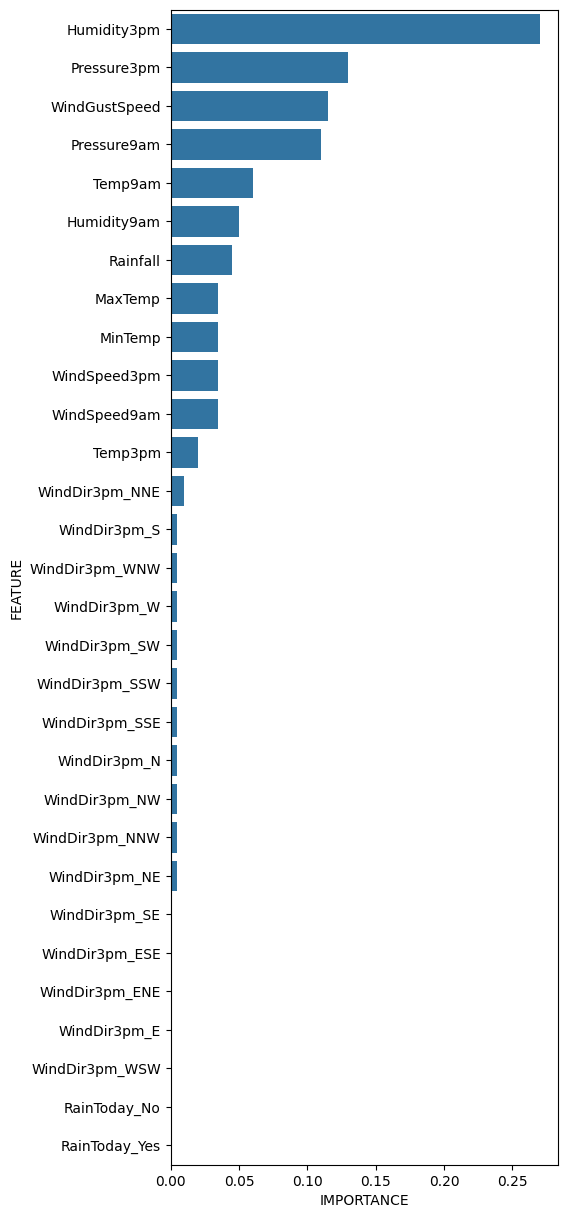

In [ ]:
plt.figure(figsize=(5, 15))
sns.barplot(y=fi2.FEATURE, x=fi2.IMPORTANCE)
plt.show()

### XGBOOST

Ahora probaremos XGBOOST: [https://xgboost.readthedocs.io/en/latest/python/index.html](https://xgboost.readthedocs.io/en/latest/python/index.html).

En google colab, xgboost ya está instalado por lo que no es necesario instalarlo. Si utilizan otro entorno, probablemente tengan que instalarlo con pip.

In [ ]:
from xgboost import XGBClassifier

Entrenar el classifier y generar las predicciones junto al classification report.

Podemos explorar sus hiperparámetros en: https://xgboost.readthedocs.io/en/latest/parameter.html

Utilizar como **n_estimators=200.**

Midan el tiempo con %%time y lo comparemos con Adaboost

In [ ]:
xgb = XGBClassifier(n_estimators=200)

In [ ]:
%%time
xgb.fit(X_train, y_train)
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94     74409
           1       0.88      0.67      0.76     20803

    accuracy                           0.91     95212
   macro avg       0.90      0.82      0.85     95212
weighted avg       0.91      0.91      0.90     95212

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     18603
           1       0.73      0.55      0.62      5201

    accuracy                           0.86     23804
   macro avg       0.81      0.74      0.77     23804
weighted avg       0.85      0.86      0.85     23804

CPU times: user 17.5 s, sys: 76.9 ms, total: 17.5 s
Wall time: 18.9 s


En xgboost también podemos acceder a feature_importances. Graficar:

In [ ]:
fi3 = pd.DataFrame(columns=["FEATURE", "IMPORTANCE"])
fi3["FEATURE"] = X_train.columns
fi3["IMPORTANCE"] = xgb.feature_importances_
fi3 = fi3.sort_values("IMPORTANCE", ascending=False)

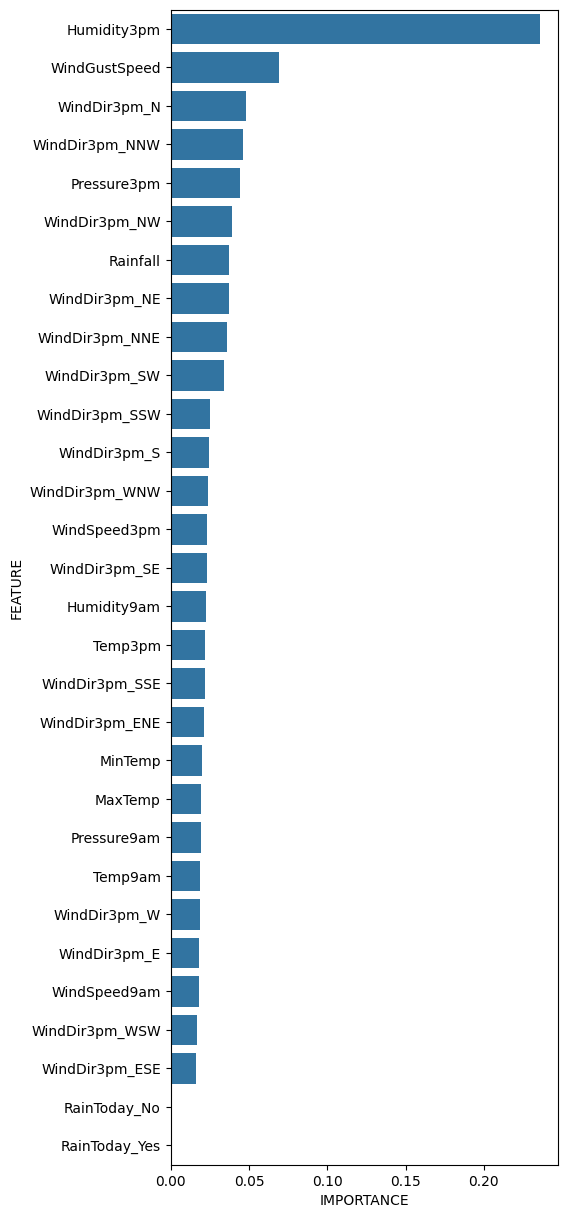

In [ ]:
plt.figure(figsize=(5, 15))
sns.barplot(y=fi3.FEATURE, x=fi3.IMPORTANCE)
plt.show()

### LIGHT GBM

Otra librería que implementa un modelo de boosting muy eficiente es LightGBM: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

Vamos a probarla en nuestro conjunto de datos.

Entrenar, medir métricas y graficar feature importance.

Recuerden medir el tiempo que tarda en entrenar para comparar con los anteriores.

Vamos a utilizar 200 como n_estimators nuevamente, para comparar los resultados de todos los modelos.

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
lgbm = LGBMClassifier(n_estimators=200)

In [ ]:
%%time
lgbm.fit(X_train, y_train)
y_train_pred = lgbm.predict(X_train)
y_test_pred = lgbm.predict(X_test)

print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

[LightGBM] [Info] Number of positive: 20803, number of negative: 74409
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2162
[LightGBM] [Info] Number of data points in the train set: 95212, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218491 -> initscore=-1.274480
[LightGBM] [Info] Start training from score -1.274480
              precision    recall  f1-score   support

           0       0.89      0.96      0.92     74409
           1       0.80      0.57      0.67     20803

    accuracy                           0.87     95212
   macro avg       0.84      0.76      0.79     95212
weighted avg       0.87      0.87      0.87     95212

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     18603
      

### Stacking

Finalmente, armaremos un stacking de modelos utilizando sklearn.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html

En este caso, los estimadores los tenemos que pasar en el parámetro "estimators" y el final estimator, en "final_estimator".

Utilizaremos los estimadores:

- random forest: RandomForestClassifier(max_depth=10, n_estimators = 200, n_jobs = -1, random_state=0)

- xgbooost: XGBClassifier(n_estimators=200)

- Ligth gbm: LGBMClassifier(n_estimators=200)

y como final estimator un DecisionTreeClassifier(max_depth=5)

Armar el modelo de stacking:


In [ ]:
from sklearn.ensemble import StackingClassifier

estimadores = [('rf', RandomForestClassifier(max_depth=10, n_estimators = 200, n_jobs = -1, random_state=0)),
              ('xgb', XGBClassifier(n_estimators=200)),
              ('lgbm', LGBMClassifier(n_estimators=200))]
clf2 = StackingClassifier(estimators = estimadores, final_estimator = DecisionTreeClassifier(max_depth=5))


Entrenarlo e imprimir classification report (recuerden medir el tiempo).

Va a tardar unos minutos.

In [ ]:
%%time
clf2.fit(X_train, y_train)
y_train_pred = clf2.predict(X_train)
y_test_pred = clf2.predict(X_test)

print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

[LightGBM] [Info] Number of positive: 20803, number of negative: 74409
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2162
[LightGBM] [Info] Number of data points in the train set: 95212, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.218491 -> initscore=-1.274480
[LightGBM] [Info] Start training from score -1.274480
[LightGBM] [Info] Number of positive: 16642, number of negative: 59527
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2158
[LightGBM] [Info] Number of data points in the train set: 76169, number of used features: 30
[LightGBM] [Info] 